In [2]:
#!/usr/bin/env python2
# -*- coding: utf-8 -*-
"""
Created on Tue Apr 10 15:10:00 2018

@author: juliana
"""


import h5py
import os
import json
import cv2
import time
import math
import optparse
import pandas as pd
import numpy as np
import pylab as pl
import matplotlib as mpl
import seaborn as sns
import pyvttbl as pt
import multiprocessing as mp
import tifffile as tf
from collections import namedtuple
from scipy import stats
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
import scikit_posthocs as sp
from statsmodels.stats.multicomp import pairwise_tukeyhsd, MultiComparison

from pipeline.python.utils import natural_keys, replace_root, print_elapsed_time
import pipeline.python.traces.combine_runs as cb
import pipeline.python.paradigm.align_acquisition_events as acq
import pipeline.python.visualization.plot_psths_from_dataframe as vis
from pipeline.python.traces.utils import load_TID


/home/juliana/anaconda/envs/pipeline/lib/python2.7/site-packages/matplotlib/__init__.py:1401: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [3]:
def extract_options(options):

    parser = optparse.OptionParser()

    parser.add_option('-D', '--root', action='store', dest='rootdir',
                          default='/nas/volume1/2photon/data',
                          help='data root dir (dir containing all animalids) [default: /nas/volume1/2photon/data, /n/coxfs01/2pdata if --slurm]')
    parser.add_option('-i', '--animalid', action='store', dest='animalid',
                          default='', help='Animal ID')

    # Set specific session/run for current animal:
    parser.add_option('-S', '--session', action='store', dest='session',
                          default='', help='session dir (format: YYYMMDD_ANIMALID')
    parser.add_option('-A', '--acq', action='store', dest='acquisition',
                          default='FOV1', help="acquisition folder (ex: 'FOV1_zoom3x') [default: FOV1]")
    parser.add_option('-T', '--trace-type', action='store', dest='trace_type',
                          default='raw', help="trace type [default: 'raw']")

    parser.add_option('-R', '--run', dest='run_list', default=[], nargs=1,
                          action='append',
                          help="run ID in order of runs")
    parser.add_option('-t', '--traceid', dest='traceid_list', default=[], nargs=1,
                          action='append',
                          help="trace ID in order of runs")
    parser.add_option('-n', '--nruns', action='store', dest='nruns', default=1, help="Number of consecutive runs if combined")

    parser.add_option('--slurm', action='store_true', dest='slurm', default=False, help="set if running as SLURM job on Odyssey")
    parser.add_option('--par', action='store_true', dest='multiproc', default=False, help="set if want to run MP on roi stats, when possible")
    parser.add_option('--nproc', action='store', dest='nprocesses', default=4, help="N processes if running in par (default=4)")

    parser.add_option('--combo', action='store_true', dest='combined', default=False, help="Set if using combined runs with same default name (blobs_run1, blobs_run2, etc.)")


    # Pupil filtering info:
    parser.add_option('--no-pupil', action="store_false",
                      dest="filter_pupil", default=True, help="Set flag NOT to filter PSTH traces by pupil threshold params")
    parser.add_option('-s', '--radius-min', action="store",
                      dest="pupil_radius_min", default=25, help="Cut-off for smnallest pupil radius, if --pupil set [default: 25]")
    parser.add_option('-B', '--radius-max', action="store",
                      dest="pupil_radius_max", default=65, help="Cut-off for biggest pupil radius, if --pupil set [default: 65]")
    parser.add_option('-d', '--dist', action="store",
                      dest="pupil_dist_thr", default=5, help="Cut-off for pupil distance from start, if --pupil set [default: 5]")

    (options, args) = parser.parse_args(options)

    return options

In [4]:
def load_roi_dataframe(roidata_filepath):

    fn_parts = os.path.split(roidata_filepath)[-1].split('_')
    roidata_hash = fn_parts[1]
    trace_type = os.path.splitext(fn_parts[-1])[0]

    df_list = []

    df = pd.HDFStore(roidata_filepath, 'r')
    datakeys = df.keys()
    if 'roi' in datakeys[0]:
        for roi in datakeys:
            if '/' in roi:
                roiname = roi[1:]
            else:
                roiname = roi
            dfr = df[roi]
            dfr['roi'] = pd.Series(np.tile(roiname, (len(dfr .index),)), index=dfr.index)
            df_list.append(dfr)
        DATA = pd.concat(df_list, axis=0, ignore_index=True)
        datakey = '%s_%s' % (trace_type, roidata_hash)
    else:
        print "Found %i datakeys" % len(datakeys)
        datakey = datakeys[0]
        df.close()
        del df
        DATA = pd.read_hdf(roidata_filepath, datakey)
        #DATA = df[datakey]

    return DATA, datakey

# Set options:

In [5]:

options = ['-D', '/mnt/odyssey', '-i', 'CE077', '-S', '20180413', '-A', 'FOV1_zoom1x',
           '-T', 'np_subtracted', '--no-pupil',
           '-R', 'gratings_run1', '-t', 'traces001',
           '-n', '1']



In [6]:

options = extract_options(options)

rootdir = options.rootdir
animalid = options.animalid
session = options.session
acquisition = options.acquisition
slurm = options.slurm
if slurm is True:
    rootdir = '/n/coxfs01/2p-data'

trace_type = options.trace_type

run_list = options.run_list
traceid_list = options.traceid_list

filter_pupil = options.filter_pupil
pupil_radius_max = float(options.pupil_radius_max)
pupil_radius_min = float(options.pupil_radius_min)
pupil_dist_thr = float(options.pupil_dist_thr)
pupil_max_nblinks = 0

multiproc = options.multiproc
nprocesses = int(options.nprocesses)
combined = options.combined
nruns = int(options.nruns)

acquisition_dir = os.path.join(rootdir, animalid, session, acquisition)
if combined is False:
    runfolder = run_list[0]
    traceid = traceid_list[0]
    with open(os.path.join(acquisition_dir, runfolder, 'traces', 'traceids_%s.json' % runfolder), 'r') as f:
        tdict = json.load(f)
    tracefolder = '%s_%s' % (traceid, tdict[traceid]['trace_hash'])
    traceid_dir = os.path.join(rootdir, animalid, session, acquisition, runfolder, 'traces', tracefolder)
else:
    assert len(run_list) == nruns, "Incorrect runs or number of runs (%i) specified!\n%s" % (nruns, str(run_list))
    runfolder = '_'.join(run_list)
    if len(traceid_list)==1:
        traceid = '_'.join([traceid_list[0] for i in range(nruns)])
    traceid_dir = os.path.join(rootdir, animalid, session, acquisition, runfolder, traceid)


print(traceid_dir)
assert os.path.exists(traceid_dir), "Specified traceid-dir does not exist!"

/mnt/odyssey/CE077/20180413/FOV1_zoom1x/gratings_run1/traces/traces001_3183c3


### Load ROIDATA file

In [7]:

roidf_fn = [i for i in os.listdir(traceid_dir) if i.endswith('hdf5') and 'ROIDATA' in i][0]
roidata_filepath = os.path.join(traceid_dir, roidf_fn) #'ROIDATA_098054_626d01_raw.hdf5')
DATA, datakey = load_roi_dataframe(roidata_filepath)

transform_dict, object_transformations = vis.get_object_transforms(DATA)
trans_types = object_transformations.keys()


[0, 45, 90, 135]
[0.10000000000000001, 0.5]


#### Filter by pupil data, if relevant:

In [8]:
if filter_pupil is True:
    pupil_params = acq.set_pupil_params(radius_min=pupil_radius_min,
                                        radius_max=pupil_radius_max,
                                        dist_thr=pupil_dist_thr,
                                        create_empty=False)
elif filter_pupil is False:
    pupil_params = acq.set_pupil_params(create_empty=True)

#### Calculate ROI STATS, if nec:

In [9]:
print "Getting ROI STATS..."
STATS, stats_filepath = cb.get_combined_stats(DATA, datakey, traceid_dir, trace_type=trace_type, filter_pupil=filter_pupil, pupil_params=pupil_params)


Getting ROI STATS...
Requested METRIC: unfiltered_2513448523829438896
Found metrics: [u'unfiltered_2513448523829438896']
Renamed hash to match existing.
Saved roiparams to .json
STATS keys: ['/df']
Retrieved existing STATS file:
/mnt/odyssey/CE077/20180413/FOV1_zoom1x/gratings_run1/traces/traces001_3183c3/metrics/unfiltered_2513448523829438896/roi_stats_2513448523829438896_np_subtracted_20180417210024.hdf5


#### Set OUTPUT dirs:

In [10]:

if '/' in datakey:
    datakey = datakey[1:]
sort_dir = os.path.join(traceid_dir, 'sorted_%s' % datakey)
sort_resultsdir = os.path.join(sort_dir, 'anova_results')
sort_figdir = os.path.join(sort_dir, 'figures')

responsive_resultsdir = os.path.join(sort_dir, 'anova_results', 'responsive_tests')
selective_resultsdir = os.path.join(sort_dir, 'anova_results', 'selectivity_tests')

if not os.path.exists(sort_figdir):
    os.makedirs(sort_figdir)

if not os.path.exists(responsive_resultsdir):
    os.makedirs(responsive_resultsdir)
if not os.path.exists(selective_resultsdir):
    os.makedirs(selective_resultsdir)

tolerance_figdir = os.path.join(sort_dir, 'figures', 'tolerance')
if not os.path.exists(tolerance_figdir):
    os.makedirs(tolerance_figdir)

#### Get stimulus info:

In [11]:

rundir = os.path.join(rootdir, animalid, session, acquisition, runfolder)

if combined is True:
    stimconfigs_fpath = os.path.join(traceid_dir, 'stimulus_configs.json')
else:
    stimconfigs_fpath = os.path.join(rundir, 'paradigm', 'stimulus_configs.json')

with open(stimconfigs_fpath, 'r') as f:
    stimconfigs = json.load(f)

print "Loaded %i stimulus configurations." % len(stimconfigs.keys())


Loaded 8 stimulus configurations.


In [12]:
%matplotlib notebook

# Dimensionality Reduction

In [13]:
from statsmodels.multivariate.pca import PCA as smPCA
from statsmodels.multivariate.pca import PCA as smPCA
from sklearn.decomposition import PCA as skPCA
from sklearn.preprocessing import StandardScaler


### Look at a single trial:

In [14]:
trial = 'trial00001'
test = DATA[DATA['trial']==trial]
roi_list = sorted(list(set(test['roi'])), key=natural_keys)
nvals = len(test[test['roi']==roi_list[0]]['df'].values)
X = np.empty((nvals, len(roi_list)))
for ri, roi in enumerate(sorted(list(set(test['roi'])), key=natural_keys)):
    X[:,ri] = test[test['roi']==roi]['df'].values

pc = smPCA(X)


<IPython.core.display.Javascript object>


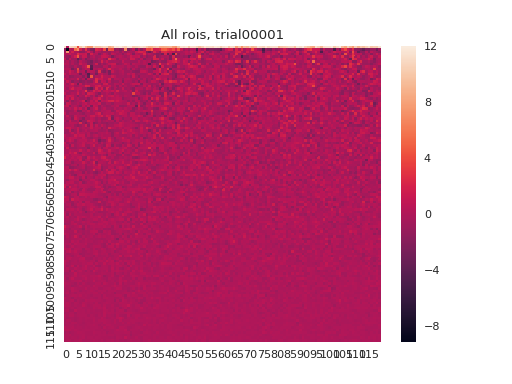

Text(0.5,1,u'All rois, trial00001')

In [46]:

pl.figure()
sns.heatmap(pc.coeff)
pl.title('All rois, %s' % trial)

<IPython.core.display.Javascript object>


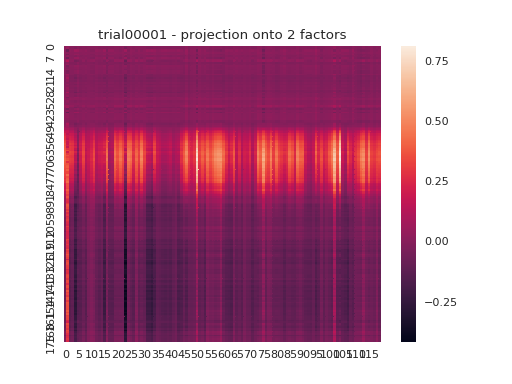

N obs: 179, N vars: 120


In [57]:
# Visualize PROJECTION: nobs by var array containing the projection of the data onto the ncomp estimated factors
ncomp = pc.factors.shape[1]

pl.figure()
sns.heatmap(pc.project(2))
pl.title('%s - projection onto 2 factors' % (trial))
print "N obs: %i, N vars: %i" % (pc.projection.shape[0], pc.projection.shape[1])

<IPython.core.display.Javascript object>


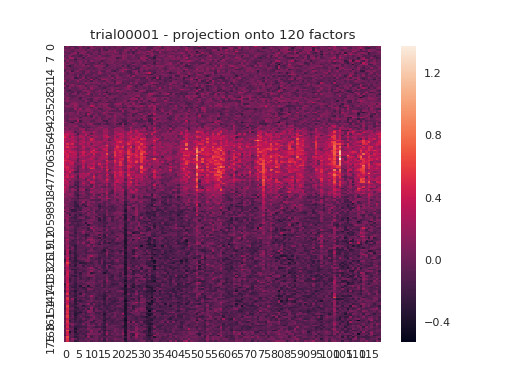

N obs: 179, N vars: 120


In [51]:

pl.figure()
sns.heatmap(pc.projection)
pl.title('%s - projection onto %i factors' % (trial, ncomp))
print "N obs: %i, N vars: %i" % (pc.projection.shape[0], pc.projection.shape[1])

<IPython.core.display.Javascript object>


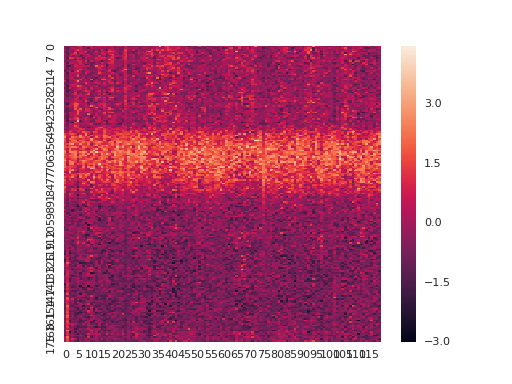

In [58]:
pl.figure()
sns.heatmap(pc.transformed_data)

<IPython.core.display.Javascript object>


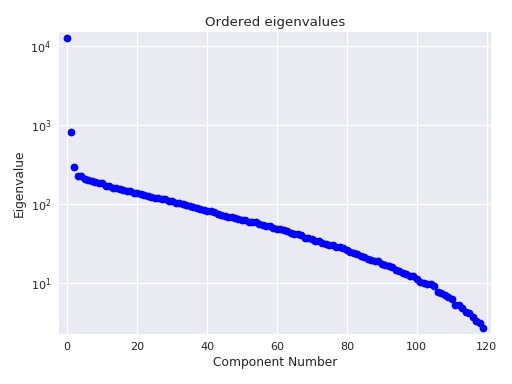

Text(0.5,1,u'Ordered eigenvalues')

In [59]:
pc.plot_scree()
pl.title('Ordered eigenvalues')

<IPython.core.display.Javascript object>


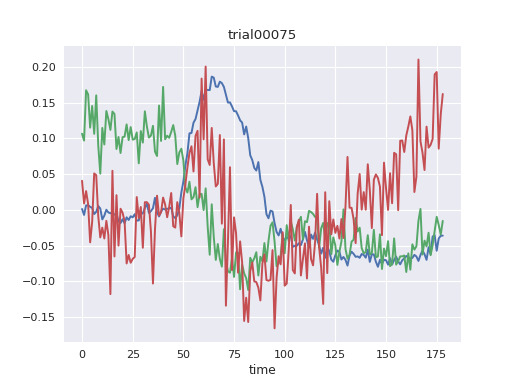

Text(0.5,1,u'trial00075')

In [272]:
# factors - basis functions -- these same across trials
# loadings - weightings for 1 particular "trial" 0-- these vary between trials


pl.figure();
pl.plot(pc.scores[:,0], label='pc1')
pl.plot(pc.scores[:,1], label='pc2')
pl.plot(pc.scores[:,2], label='pc3')
pl.xlabel('time')
pl.title(trial)

In [277]:
pc.projection.shape

(179, 120)

<IPython.core.display.Javascript object>


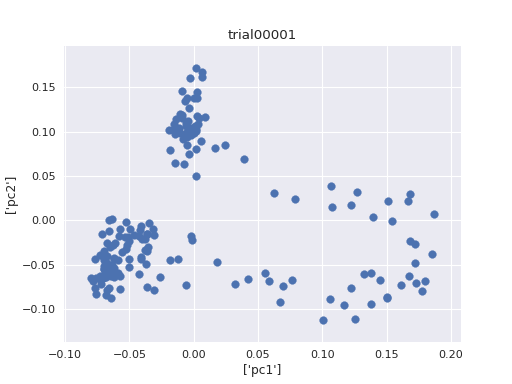

Text(0.5,1,u'trial00001')

In [44]:

pl.figure(); pl.scatter(pc.scores[:,0], pc.scores[:,1])
pl.xlabel(['pc1'])
pl.ylabel(['pc2'])
pl.title(trial)

In [ ]:
pc.scores.shape

<IPython.core.display.Javascript object>


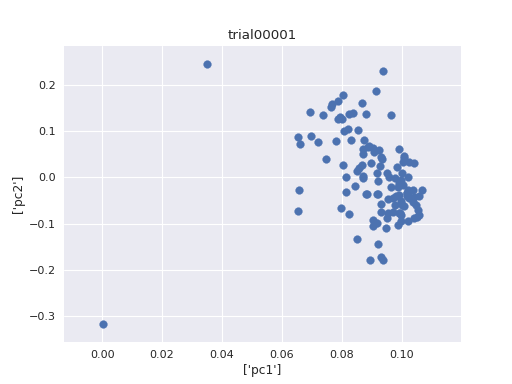

Text(0.5,1,u'trial00001')

In [182]:
pl.figure(); pl.scatter(pc.loadings[:,0], pc.loadings[:,1])
pl.xlabel(['pc1'])
pl.ylabel(['pc2'])
pl.title(trial)


<IPython.core.display.Javascript object>


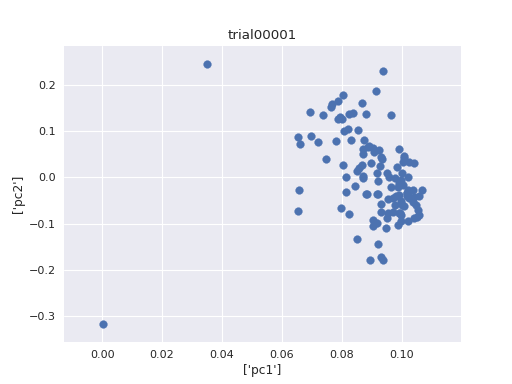

Text(0.5,1,u'trial00001')

In [157]:
pl.figure(); pl.scatter(pc.loadings[:,0], pc.loadings[:,1])
pl.xlabel(['pc1'])
pl.ylabel(['pc2'])
pl.title(trial)

pc.transformed_data[:,18]

In [184]:
pc.transformed_data[:,18]

(179, 120)

<IPython.core.display.Javascript object>


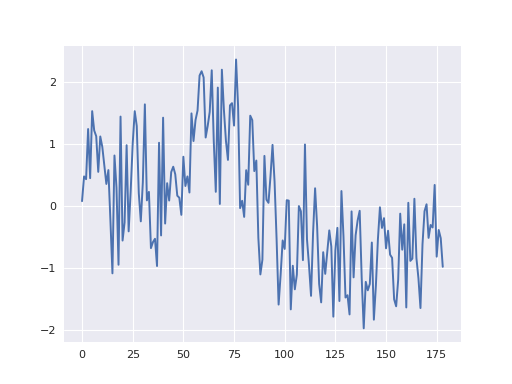

In [185]:
pl.figure()
pl.plot(pc.transformed_data[:,18])

### Look at single config:

In [148]:
config = 'config007'
test = DATA[DATA['config']==config]
roi_list = sorted(list(set(test['roi'])), key=natural_keys)
nvals = len(test[test['roi']==roi_list[0]]['df'].values)
X = np.empty((nvals, len(roi_list)))
for ri, roi in enumerate(sorted(list(set(test['roi'])), key=natural_keys)):
    X[:,ri] = test[test['roi']==roi]['df'].values

pc_config = smPCA(X)


<IPython.core.display.Javascript object>


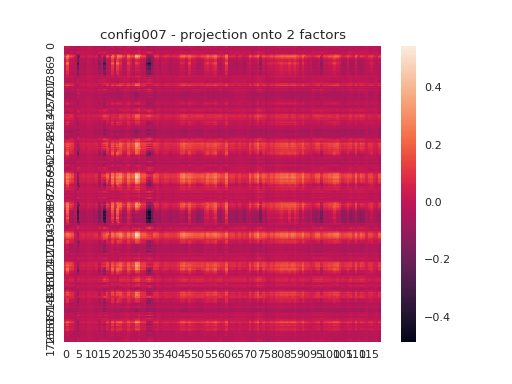

N obs: 1790, N vars: 120


In [149]:
# Visualize PROJECTION: nobs by var array containing the projection of the data onto the ncomp estimated factors
ncomp = pc_config.factors.shape[1]

pl.figure()
sns.heatmap(pc_config.project(2))
pl.title('%s - projection onto 2 factors' % (config))
print "N obs: %i, N vars: %i" % (pc_config.projection.shape[0], pc_config.projection.shape[1])

<IPython.core.display.Javascript object>


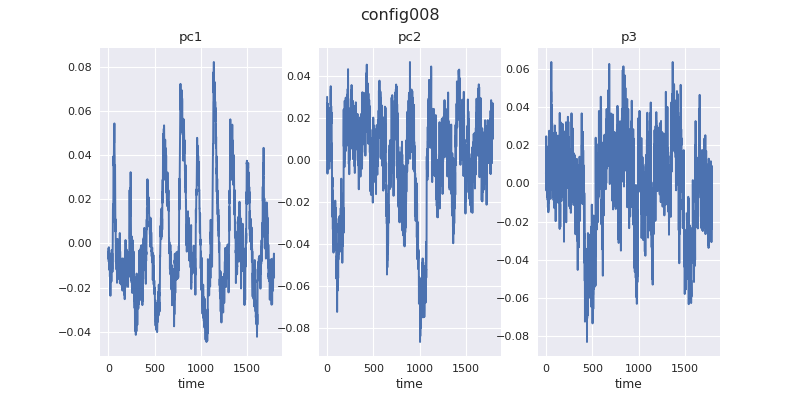

Text(0.5,0.98,u'config008')

In [205]:
pl.figure(figsize=(10,5));
pl.subplot(1,3,1)
pl.plot(pc_config.scores[:,0], label='pc1')
pl.xlabel('time')
pl.title('pc1')

pl.subplot(1,3,2)
pl.plot(pc_config.scores[:,1], label='pc2')
pl.xlabel('time')
pl.title('pc2')

pl.subplot(1,3,3)
pl.plot(pc_config.scores[:,2], label='pc3')
pl.xlabel('time')
pl.title('p3')
pl.suptitle(config)

<IPython.core.display.Javascript object>


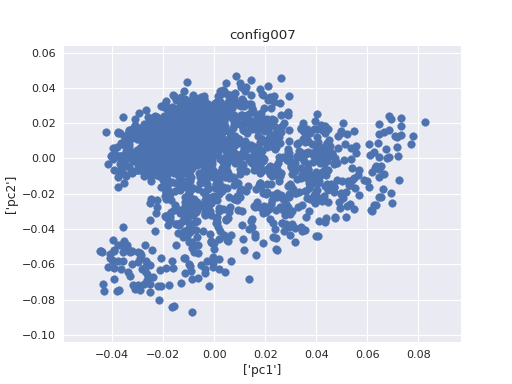

Text(0.5,1,u'config007')

In [155]:

pl.figure(); pl.scatter(pc_config.scores[:,0], pc_config.scores[:,1])
pl.xlabel(['pc1'])
pl.ylabel(['pc2'])
pl.title(config)

<IPython.core.display.Javascript object>


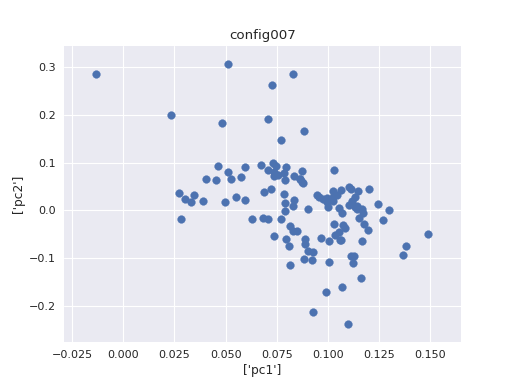

Text(0.5,1,u'config007')

In [158]:
pl.figure(); pl.scatter(pc_config.loadings[:,0], pc_config.loadings[:,1])
pl.xlabel(['pc1'])
pl.ylabel(['pc2'])
pl.title(config)

In [213]:
from mpl_toolkits.mplot3d import Axes3D


<IPython.core.display.Javascript object>


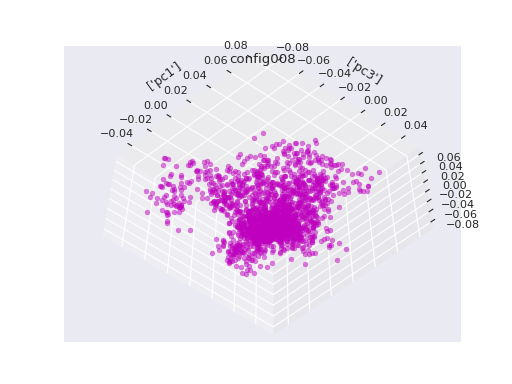

Text(0.5,0.92,u'config008')

In [278]:
fig = pl.figure(); 
ax = fig.add_subplot(111, projection='3d')
# pl.scatter(pc_config.scores[:,0], 
#            pc_config.scores[:,1], 
#            pc_config.scores[:,2], s=50)
for xs, ys, zs in zip(pc_config.scores[:,0],pc_config.scores[:,1], pc_config.scores[:,2]):
    ax.scatter(xs, ys, zs, c='m', s=20, alpha=0.5)
pl.xlabel(['pc1'])
pl.ylabel(['pc2'])
pl.ylabel(['pc3'])
pl.title(config)

In [24]:

def get_mean_traces(DF1):
    config_list =  sorted(list(set(DF1['config'])), key=natural_keys)
    grp = DF1.groupby(['config', 'trial'])
    dff_traces = dict((c, []) for c in config_list)
    for k, g in grp:
        dff_traces[k[0]].append(g['df'].values)

    meandf = []
    for c in dff_traces.keys():
        mean_df_traces = np.mean(np.array(dff_traces[c]), axis=0)
        nframes = len(mean_df_traces)
        meandf.append(pd.DataFrame({'config': np.tile(c, (nframes,)),
                      'dff': mean_df_traces
                      }))

    M1 = pd.concat(meandf)

    return M1

import matplotlib.cm as cm


#### Select 2 ROIs to look at in "2D" space:

In [25]:

roi1 = 'roi00029'
roi2 = 'roi00019'


In [26]:
config_list = sorted(list(set(DATA['config'])), key=natural_keys)


rdata1 = DATA[DATA['roi']==roi1]
rdata2 = DATA[DATA['roi']==roi2]

#config = 'config007' #config_list[0]
#configdf1 = rdata1[rdata1['config']==config][['trial', 'df']].sort_values(['trial'])
#configdf2 = rdata2[rdata2['config']==config][['trial', 'df']].sort_values(['trial'])

#trial_list = list(set(configdf2['trial']))

DF1 = rdata1[['config', 'trial', 'df']]
DF2 = rdata2[['config', 'trial', 'df']]

M1 = get_mean_traces(DF1)
M2 = get_mean_traces(DF2)


#### Here, look at ORI responses for each SF:

In [27]:

curr_sf = 0.5
dff_plot_title = 'SF %.2f' % curr_sf

<IPython.core.display.Javascript object>


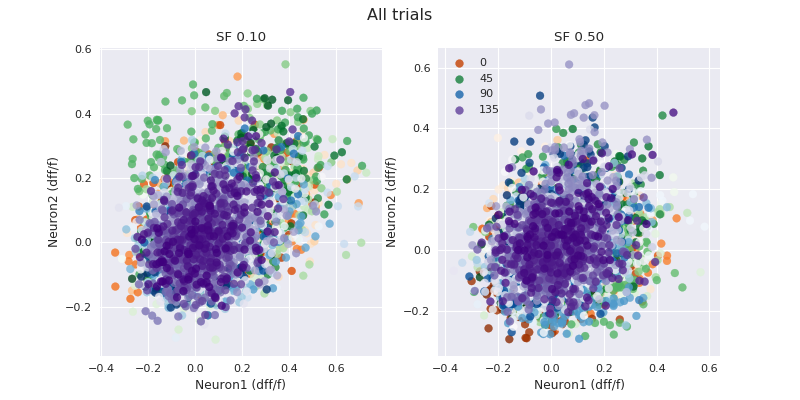

Text(0.5,0.98,u'All trials')

In [189]:
sfs = [0.1, 0.5]
#configs = sorted([c for c in stimconfigs.keys() if stimconfigs[c]['frequency']==curr_sf], key=lambda x: stimconfigs[x]['rotation'])

sns.set()
pl.figure(figsize=(10,5))
pidx = 1
for curr_sf in sfs:
    pl.subplot(1,2,pidx)
    dff_plot_title = 'SF %.2f' % curr_sf
    
    configs = sorted([c for c in stimconfigs.keys() if stimconfigs[c]['frequency']==curr_sf], key=lambda x: stimconfigs[x]['rotation'])

    cmap_list = [cm.Oranges, cm.Greens, cm.Blues, cm.Purples]
    for ci, currconfig in enumerate(configs):
        #pl.plot(M1[M1['config']==currconfig]['dff'].values, M2[M2['config']==currconfig]['dff'].values)
        cmap = cmap_list[ci]
        ntpoints = len(DF1[DF1['config']==currconfig]['df'])
        cds = np.linspace(0, ntpoints, num=ntpoints*5)
        c = cds[0::5]
        resp1 = DF1[DF1['config']==currconfig]['df'].values
        resp2 = DF2[DF2['config']==currconfig]['df'].values

        #resp1 = np.linspace(0, ntpoints)
        pl.scatter(resp1, resp2, c=c, cmap=cmap, s=50, alpha=0.8, label=stimconfigs[currconfig]['rotation'])

    pl.xlabel('Neuron1 (dff/f)')
    pl.ylabel('Neuron2 (dff/f)')
    pl.title(dff_plot_title)
    pidx += 1

#pl.colorbar()
pl.legend()
ax = pl.gca()
legend = ax.get_legend()
for cidx in range(len(configs)):
    legend.legendHandles[cidx].set_color(cmap_list[cidx](0.8))

pl.suptitle('All trials')

#### Try looking at the mean df/f trace across trials:

<IPython.core.display.Javascript object>


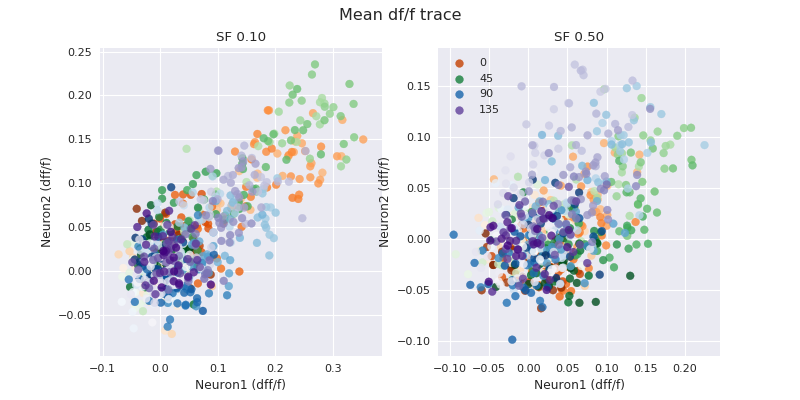

Text(0.5,0.98,u'Mean df/f trace')

In [190]:

sfs = [0.1, 0.5]
#configs = sorted([c for c in stimconfigs.keys() if stimconfigs[c]['frequency']==curr_sf], key=lambda x: stimconfigs[x]['rotation'])

sns.set()
pl.figure(figsize=(10,5))
pidx = 1
for curr_sf in sfs:
    pl.subplot(1,2,pidx)
    dff_plot_title = 'SF %.2f' % curr_sf
    
    configs = sorted([c for c in stimconfigs.keys() if stimconfigs[c]['frequency']==curr_sf], key=lambda x: stimconfigs[x]['rotation'])

    cmap_list = [cm.Oranges, cm.Greens, cm.Blues, cm.Purples]
    for ci, currconfig in enumerate(configs):
        #pl.plot(M1[M1['config']==currconfig]['dff'].values, M2[M2['config']==currconfig]['dff'].values)
        cmap = cmap_list[ci]
        ntpoints = len(M1[M1['config']==currconfig]['dff'])
        cds = np.linspace(0, ntpoints, num=ntpoints*5)
        c = cds[0::5]
        resp1 = M1[M1['config']==currconfig]['dff'].values
        resp2 = M2[M2['config']==currconfig]['dff'].values

        #resp1 = np.linspace(0, ntpoints)
        pl.scatter(resp1, resp2, c=c, cmap=cmap, s=50, alpha=0.8, label=stimconfigs[currconfig]['rotation'])

    pl.xlabel('Neuron1 (dff/f)')
    pl.ylabel('Neuron2 (dff/f)')
    pl.title(dff_plot_title)
    pidx += 1

#pl.colorbar()
pl.legend()
ax = pl.gca()
legend = ax.get_legend()
for cidx in range(len(configs)):
    legend.legendHandles[cidx].set_color(cmap_list[cidx](0.8))

pl.suptitle('Mean df/f trace')

#### Plot single config, all trials on top of each other:

10


<IPython.core.display.Javascript object>


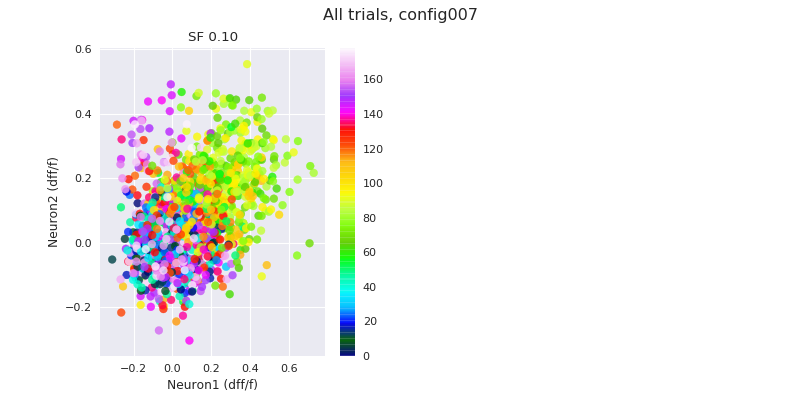

Text(0.5,0.98,u'All trials, config007')

In [201]:
sfs = [0.1] #, 0.5]
#configs = sorted([c for c in stimconfigs.keys() if stimconfigs[c]['frequency']==curr_sf], key=lambda x: stimconfigs[x]['rotation'])

currconfig = 'config007'
cmap=cm.gist_ncar

trials = sorted(list(set(DF1[DF1['config']==currconfig]['trial'])), key=natural_keys)
print len(trials)

sns.set()
pl.figure(figsize=(10,5))
pidx = 1
cid = 0
for curr_sf in sfs:
    pl.subplot(1,2,pidx)
    dff_plot_title = 'SF %.2f' % curr_sf
    
    configs = sorted([c for c in stimconfigs.keys() if stimconfigs[c]['frequency']==curr_sf], key=lambda x: stimconfigs[x]['rotation'])

   # cmap_list = [cm.Oranges, cm.Greens, cm.Blues, cm.Purples]
    for ti, trial in enumerate(trials):
        #pl.plot(M1[M1['config']==currconfig]['dff'].values, M2[M2['config']==currconfig]['dff'].values)
        #cmap = cmap_list[ci]
        ntpoints = len(DF1[((DF1['config']==currconfig) & (DF1['trial']==trial))]['df'])
        cds = np.linspace(0, ntpoints, num=ntpoints*5)
        c = cds[0::5]
        resp1 = DF1[((DF1['config']==currconfig) & (DF1['trial']==trial))]['df'].values
        resp2 = DF2[((DF2['config']==currconfig) & (DF2['trial']==trial))]['df'].values

        #resp1 = np.linspace(0, ntpoints)
        pl.scatter(resp1, resp2, c=c, cmap=cmap, s=50, alpha=0.8, label=stimconfigs[currconfig]['rotation'])

    pl.xlabel('Neuron1 (dff/f)')
    pl.ylabel('Neuron2 (dff/f)')
    pl.title(dff_plot_title)
    pidx += 1

#pl.colorbar()
# pl.legend()
# ax = pl.gca()
# legend = ax.get_legend()
# for cidx in range(len([currconfig])):
#     cidx = 0
#     legend.legendHandles[cidx].set_color(cmap_list[cidx](0.8))
pl.colorbar()
pl.suptitle('All trials, %s' % currconfig)

### Configure ROIDATA into format with ROIs as "factors"

In [15]:
#test = DATA[DATA['config']=='config003']
roi_list = sorted(list(set(DATA['roi'])), key=natural_keys)
config_list = sorted(list(set(DATA['config'])), key=natural_keys)

nvals = len(DATA[DATA['roi']==roi_list[0]]['df'].values)
data_values = np.empty((nvals, len(roi_list)))
for ri, roi in enumerate(sorted(roi_list, key=natural_keys)):
    data_values[:,ri] = DATA[DATA['roi']==roi]['df'].values


In [16]:
dataset = pd.DataFrame(data=data_values,
                       index=np.arange(0, data_values.shape[0]),
                       columns=roi_list)
dataset['config'] = DATA[DATA['roi']==roi_list[0]]['config'].values



# PCA on dataset with 1 SF, 4 orientations:

In [17]:
# Look at one SF for now:
curr_sf = 0.1

config_subset = sorted([c for c in stimconfigs.keys() if stimconfigs[c]['frequency']==curr_sf], key=lambda x: stimconfigs[x]['rotation'])

config_sublist = [str(c) for c in config_subset]
subdf = dataset[dataset['config'].isin(config_sublist)].reset_index(drop=True)


In [18]:
print list(set(subdf['config']))

[u'config007', u'config006', u'config005', u'config008']


##### Split up data in data and labels

In [19]:

nrois = len(roi_list)
X = subdf.ix[:,0:nrois].values  # Split data table into data X
y = subdf.ix[:,nrois].values    # and class labels Y

/home/juliana/anaconda/envs/pipeline/lib/python2.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  This is separate from the ipykernel package so we can avoid doing imports until


##### Standardize data:

In [20]:
X_std = StandardScaler().fit_transform(X)


##### Calculate covariance matrix:

Covariance matrix 
[[ 1.00013968  0.28602404  0.31471682 ...,  0.14328773  0.11881847
   0.30695618]
 [ 0.28602404  1.00013968  0.34130571 ...,  0.13189488  0.10786064
   0.2373709 ]
 [ 0.31471682  0.34130571  1.00013968 ...,  0.17969073  0.15464585
   0.33711836]
 ..., 
 [ 0.14328773  0.13189488  0.17969073 ...,  1.00013968  0.1777982
   0.14929265]
 [ 0.11881847  0.10786064  0.15464585 ...,  0.1777982   1.00013968
   0.13175982]
 [ 0.30695618  0.2373709   0.33711836 ...,  0.14929265  0.13175982
   1.00013968]]


<IPython.core.display.Javascript object>


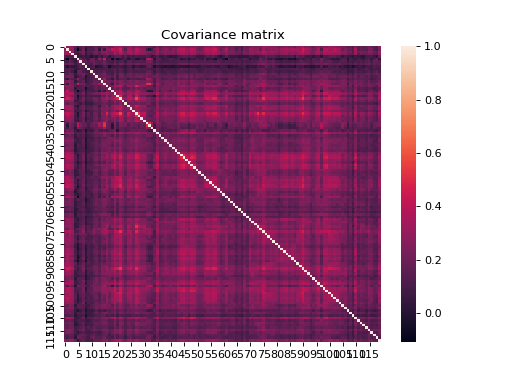

In [21]:
mean_vec = np.mean(X_std, axis=0)
cov_mat = (X_std - mean_vec).T.dot((X_std - mean_vec)) / (X_std.shape[0]-1)
print('Covariance matrix \n%s' %cov_mat)
#print('NumPy covariance matrix: \n%s' %np.cov(X_std.T))
pl.figure();
sns.heatmap(cov_mat)
pl.title("Covariance matrix")

In [22]:
cov_mat.shape

(120, 120)

##### Eigendecomposition

In [23]:
# 4a.  Eigendecomposition on cpvariance matrix:

eig_vals, eig_vecs = np.linalg.eig(cov_mat)

print('Eigenvectors \n%s' %eig_vecs)
print('\nEigenvalues \n%s' %eig_vals)

Eigenvectors 
[[ 0.09105305  0.02715913 -0.12857275 ..., -0.0221515  -0.05881779
   0.01283701]
 [ 0.1084527   0.18288021  0.05574808 ...,  0.08697735  0.00466347
   0.03155498]
 [ 0.11321643  0.00405222 -0.04017281 ..., -0.00295859 -0.04002167
  -0.00198235]
 ..., 
 [ 0.0593087  -0.07414426 -0.10271014 ..., -0.06405659  0.04473187
   0.08218866]
 [ 0.05685759 -0.12288334 -0.06948367 ..., -0.05356178 -0.02645328
   0.06575508]
 [ 0.09992278  0.02803374 -0.1441847  ..., -0.07330376 -0.12966576
   0.09825249]]

Eigenvalues 
[ 28.43583795   3.84219055   2.23662853   1.94783718   1.61405246
   1.34099013   1.27303856   1.24490451   1.16525582   1.11915227
   1.06489412   0.33098642   0.38324039   0.40275953   0.99934551
   0.98665947   0.97980365   0.96776034   0.95810805   0.41700918
   0.42596233   0.43180745   0.93742646   0.92988002   0.44231794
   0.91955797   0.91785605   0.45460976   0.46373039   0.47740144
   0.91030073   0.90252293   0.89603737   0.88333926   0.48701787
   0.87857

In [166]:

# 4b.  Eigendecomposition on CORRELATION matrix:
# NOTE:  E-decomp of COV-matrix (if input standardized) yields same results as
# E-decomp on CORR-mat, since correlation matrix is like the normalized
# covariance matrix...

# cor_mat1 = np.corrcoef(X_std.T)

# eig_vals, eig_vecs = np.linalg.eig(cor_mat1)

# print('Eigenvectors \n%s' %eig_vecs)
# print('\nEigenvalues \n%s' %eig_vals)

# # 4.c.  Eigendecomposition of RAW data based on correlation matrix:
# cor_mat2 = np.corrcoef(X.T)

# eig_vals, eig_vecs = np.linalg.eig(cor_mat2)

# print('Eigenvectors \n%s' %eig_vecs)
# print('\nEigenvalues \n%s' %eig_vals)


# # 4.d.  Use SVD instead:
# u,s,v = np.linalg.svd(X_std.T)
# # u should be the same as eigenvectors produced above



##### All eigenvectors should have unit length = 1

In [167]:
for ev in eig_vecs:
    np.testing.assert_array_almost_equal(1.0, np.linalg.norm(ev))
print('Everything ok!')


Everything ok!


##### Select principal components:

In [168]:
#% 5.i.  Sort eigenvalues from high to low to find top K eigenvectors :
# Make a list of (eigenvalue, eigenvector) tuples
eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:,i]) for i in range(len(eig_vals))]

# Sort the (eigenvalue, eigenvector) tuples from high to low
eig_pairs.sort()
eig_pairs.reverse()

# Visually confirm that the list is correctly sorted by decreasing eigenvalues
print('Eigenvalues in descending order:')
for i in eig_pairs:
    print(i[0])


Eigenvalues in descending order:
28.43583795113019
3.842190551848355
2.236628530932313
1.9478371823666853
1.6140524603801758
1.340990125522047
1.27303855809759
1.2449045135500059
1.1652558223162597
1.1191522709525195
1.0648941237053908
0.9993455127972414
0.9866594729180117
0.9798036460069058
0.9677603411180327
0.9581080483251925
0.9374264624001991
0.9298800178827499
0.9195579661926877
0.9178560455583576
0.9103007284449569
0.9025229258355799
0.8960373719962508
0.8833392623373986
0.878575963862743
0.8757964716810364
0.8612052232905922
0.8599471573896067
0.8467179108844141
0.8420747380074317
0.8409238617825916
0.8343059070855067
0.8268649323410723
0.8221934793993868
0.8169143115325429
0.8148010473907213
0.8072371026585329
0.8026370827736046
0.7968083536884037
0.792163080591203
0.785494126581471
0.7827303452203419
0.7720073272157719
0.7697191575910654
0.7663905323744954
0.7589864806090644
0.7578123593417991
0.7549728287554593
0.7530971197867883
0.7452252597841553
0.7429276824076997
0.74091

##### 5.ii.  Calculate EXPLAINED-VARIANCE:  how much information (variance) can be attributed to each of the PCs?

<IPython.core.display.Javascript object>


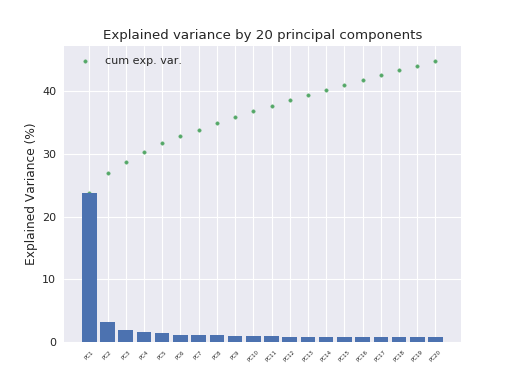

Text(0.5,1,u'Explained variance by 20 principal components')

In [169]:
tot = sum(eig_vals)
var_exp = [(i / tot)*100 for i in sorted(eig_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)

ncomps_plot = 20 #len(eig_vals)
pc_labels = ['PC%s' % i for i in range(1,ncomps_plot+1)]
x_pos = [i for i, _ in enumerate(pc_labels)]

pl.figure()

pl.bar(x_pos, var_exp[0:ncomps_plot])
pl.xticks(x_pos, pc_labels, rotation=45, fontsize=5)
pl.ylabel('Explained Variance (%)')

pl.scatter(x_pos, cum_var_exp[0:ncomps_plot], label='cum exp. var.', s=10)
pl.legend()
pl.title('Explained variance by %i principal components' % ncomps_plot)



#### 6.  Construct projection matrix to transform data onto new feature subspace:
This is a matrix of concatenated top K eigenvectors. Reduce N-d feature space to 2-D feature subspace by choosing the top 2  eigenvectors to constuct d x K-dim eigenvector W:

In [170]:
N = len(eig_vals)
matrix_w = np.hstack((eig_pairs[0][1].reshape(N,1),
                      eig_pairs[1][1].reshape(N,1)))

#print('Matrix W:\n', matrix_w)


In [178]:
matrix_w = np.hstack((eig_pairs[0][1].reshape(N,1),
                      eig_pairs[1][1].reshape(N,1),
                      eig_pairs[2][1].reshape(N,1)))


#### 7.  Projection data samples onto newspace:
Y = X x W, where Y is M x 2 matrix of transformed samples (M = n samples)

In [179]:
from mpl_toolkits.mplot3d import Axes3D


<IPython.core.display.Javascript object>


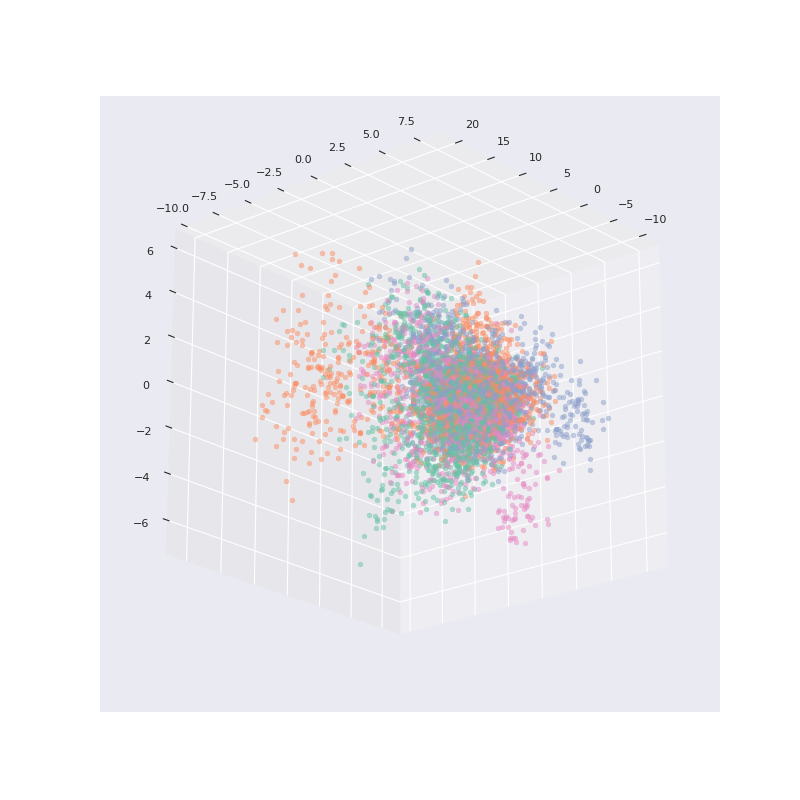

In [279]:

Y = X_std.dot(matrix_w)

config_idxs = {}
config_nums = sorted(list(set(subdf['config'])))
for config in config_nums:
    config_idxs[config] = subdf[subdf['config']==config].index.tolist()

cpalette = sns.color_palette("Set2", len(config_nums))
config_colors = dict((config, cpalette[ci]) for ci, config in enumerate(config_nums))
fig = pl.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

for config in config_nums:
    for xs,ys,zs in zip(Y[config_idxs[config], 0], Y[config_idxs[config], 1], Y[config_idxs[config], 2]):
        ax.scatter(xs, ys, zs, alpha=0.5, color=config_colors[config], label=config)
#     pl.scatter(Y[config_idxs[config], 0], Y[config_idxs[config], 1], Y[config_idxs[config], 2],
#                alpha=0.5,
#                color=config_colors[config], label=config)
#pl.legend()


In [174]:
Y[config_idxs[config], 0].shape

(1790,)

In [25]:
X.shape

(7160, 120)

# sklearn PCA

In [103]:
from sklearn.preprocessing import scale


In [30]:
from sklearn import decomposition
del data

In [161]:
x = scale(X)
n_components = 120 #120
pca = decomposition.PCA(n_components=n_components, whiten=False)
pca.fit(x) #pca.fit_transform(x)
#pc_cols = ['pc%i' % int(i+1) for i in range(n_components)]
#pcaDF = pd.DataFrame(data=pcomponents, columns=pc_cols)
print x.shape

(7160, 120)


In [162]:
pca.components_.shape # (n_components, n_features)


(120, 120)

In [163]:
loadings = pca.transform(x)  # (n_samples, n_components) project each sample into vector space spanned by the comps
print loadings.shape

(7160, 120)


In [164]:
loadings2 = pca.components_.T * np.sqrt(pca.explained_variance_)
print loadings2.shape

(120, 120)


N tpoints: 7160


<IPython.core.display.Javascript object>


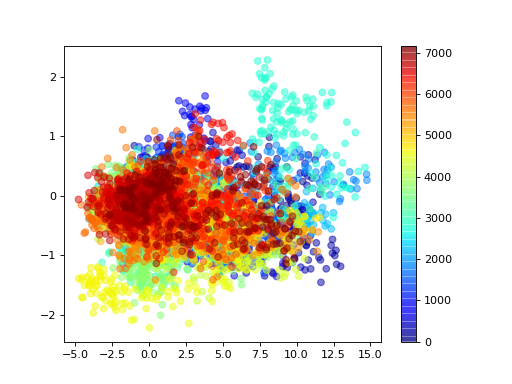

In [175]:
#pl.figure()
#pl.plot(loadings[:,0])
proj1 = loadings2[:,0].dot(X.T)
proj2 = loadings2[:,1].dot(X.T)

ntpoints = len(proj1)
print "N tpoints:", ntpoints
cds = np.linspace(0, ntpoints, num=ntpoints*5)
c = cds[0::5]
        
pl.figure()
pl.scatter(proj1, proj2, c=c, cmap=pl.cm.jet, alpha=0.5)
pl.colorbar()

# Look at single stimulus config:

In [118]:
for conf in config_subset:
    print conf, "SF %.2f, ORI %i" % (stimconfigs[conf]['frequency'], stimconfigs[conf]['rotation'])

config005 SF 0.10, ORI 0
config007 SF 0.10, ORI 45
config006 SF 0.10, ORI 90
config008 SF 0.10, ORI 135


In [144]:
currconfig = 'config003'

In [145]:
#dataset['config'] = dataset['config'].apply(lambda x: int(x[6:]))
#dataset['trial'] = dataset['trial'].apply(lambda x: int(x[5:]))

subdf = dataset[dataset['config']==currconfig].reset_index(drop=True)

features = roi_list #['roi', 'df'] #['roi', 'df', 'trial']
x = subdf.loc[:, features].values
x = StandardScaler().fit_transform(x)

y = subdf.loc[:,['config']].values

In [146]:

n_components = 3
pca = skPCA(n_components=n_components)
pcomponents = pca.fit_transform(x)
pc_cols = ['pc%i' % int(i+1) for i in range(n_components)]
principalDf = pd.DataFrame(data=pcomponents, columns = pc_cols)

subdf[['config']].head()

finalDf = pd.concat([principalDf, subdf[['config']]], axis = 1)
finalDf.head(5)

#%


pc1       pc2       pc3     config
0 -3.640480  0.355238 -0.015243  config003
1 -3.716936 -0.624906  1.334664  config003
2 -2.949837  2.776419 -1.470335  config003
3 -3.029200  1.282466 -1.077854  config003
4 -2.647514  0.181827  0.069948  config003

<IPython.core.display.Javascript object>


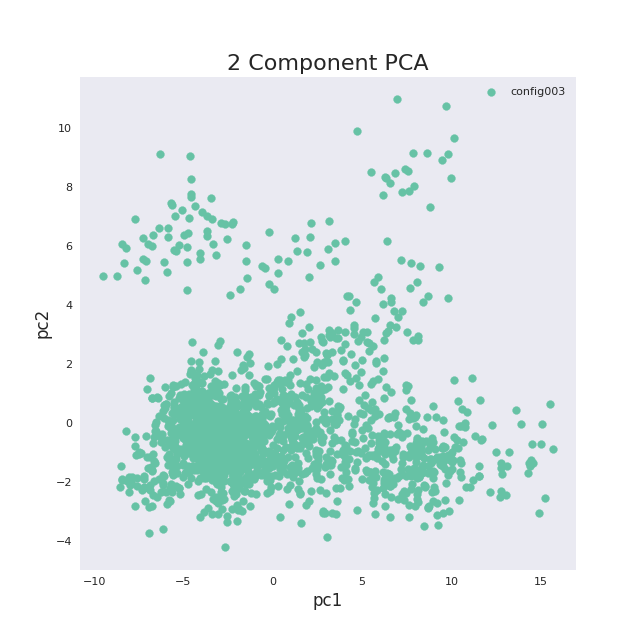

In [147]:
fig = pl.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1)
ax.set_title('2 Component PCA', fontsize = 20)

targets = [currconfig] #[int(conf[6:]) for conf in config_list]
colors = sns.color_palette("Set2", len(targets))

pcs_plot = ['pc1', 'pc2']
# pcs_plot = ['pc1', 'pc2']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['config'] == target
    ax.scatter(finalDf.loc[indicesToKeep, pcs_plot[0]]
               , finalDf.loc[indicesToKeep, pcs_plot[1]]
               , c = color
               , s = 50)
ax.set_xlabel(pcs_plot[0], fontsize=15) # 'Principal Component 1', fontsize = 15)
ax.set_ylabel(pcs_plot[1], fontsize=15) #'Principal Component 2', fontsize = 15)

ax.legend(targets)
ax.grid()

In [173]:
finalDf.loc[indicesToKeep, pcs_plot[0]].shape

(1790,)

# t-SNE

In [229]:
from sklearn.decomposition import PCA
import time
from sklearn.manifold import TSNE


#### Run t-SNE:

In [263]:
feat_cols = [f for f in dataset.columns if 'roi' in f]


In [256]:

#n_sne = 7000

time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
#tsne_results = tsne.fit_transform(df.loc[rndperm[:n_sne],feat_cols].values)
tsne_results = tsne.fit_transform(dataset[feat_cols].values)
print 't-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start)



[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 14320 samples in 0.042s...
[t-SNE] Computed neighbors for 14320 samples in 44.847s...
[t-SNE] Computed conditional probabilities for sample 1000 / 14320
[t-SNE] Computed conditional probabilities for sample 2000 / 14320
[t-SNE] Computed conditional probabilities for sample 3000 / 14320
[t-SNE] Computed conditional probabilities for sample 4000 / 14320
[t-SNE] Computed conditional probabilities for sample 5000 / 14320
[t-SNE] Computed conditional probabilities for sample 6000 / 14320
[t-SNE] Computed conditional probabilities for sample 7000 / 14320
[t-SNE] Computed conditional probabilities for sample 8000 / 14320
[t-SNE] Computed conditional probabilities for sample 9000 / 14320
[t-SNE] Computed conditional probabilities for sample 10000 / 14320
[t-SNE] Computed conditional probabilities for sample 11000 / 14320
[t-SNE] Computed conditional probabilities for sample 12000 / 14320
[t-SNE] Computed conditional probabilities for s

#### Visualize:

In [247]:
import sys
!conda install --yes --prefix {sys.prefix} -c conda-forge ggplot 

Fetching package metadata .............
Solving package specifications: .

Package plan for installation in environment /home/juliana/anaconda/envs/pipeline:

The following NEW packages will be INSTALLED:

    brewer2mpl: 1.4.1-py27_2    conda-forge
    ggplot:     0.11.5-py27_2   conda-forge

The following packages will be UPDATED:

    numpy:      1.11.3-py27_0               --> 1.11.3-py27_blas_openblas_203   conda-forge [blas_openblas]
    opencv:     2.4.11-nppy27_0 menpo       --> 2.4.13.4-py27_blas_openblas_200 conda-forge [blas_openblas]

The following packages will be DOWNGRADED due to dependency conflicts:

    matplotlib: 2.1.0-py27_1    conda-forge --> 2.0.0-np111py27_2               conda-forge
    pyqt:       5.6.0-py27_2    conda-forge --> 4.11.4-py27_3                   conda-forge
    qt:         5.6.2-6         conda-forge --> 4.8.7-3                                    

numpy-1.11.3-p 100% |################################| Time: 0:00:00  17.10 MB/s | ETA:  0:00:01  

In [248]:
from ggplot import *

/home/juliana/anaconda/envs/pipeline/lib/python2.7/site-packages/ggplot/utils.py:81: FutureWarning: pandas.tslib is deprecated and will be removed in a future version.
You can access Timestamp as pandas.Timestamp
  pd.tslib.Timestamp,
/home/juliana/anaconda/envs/pipeline/lib/python2.7/site-packages/ggplot/stats/smoothers.py:4: FutureWarning: The pandas.lib module is deprecated and will be removed in a future version. These are private functions and can be accessed from pandas._libs.lib instead
  from pandas.lib import Timestamp
/home/juliana/anaconda/envs/pipeline/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


<IPython.core.display.Javascript object>


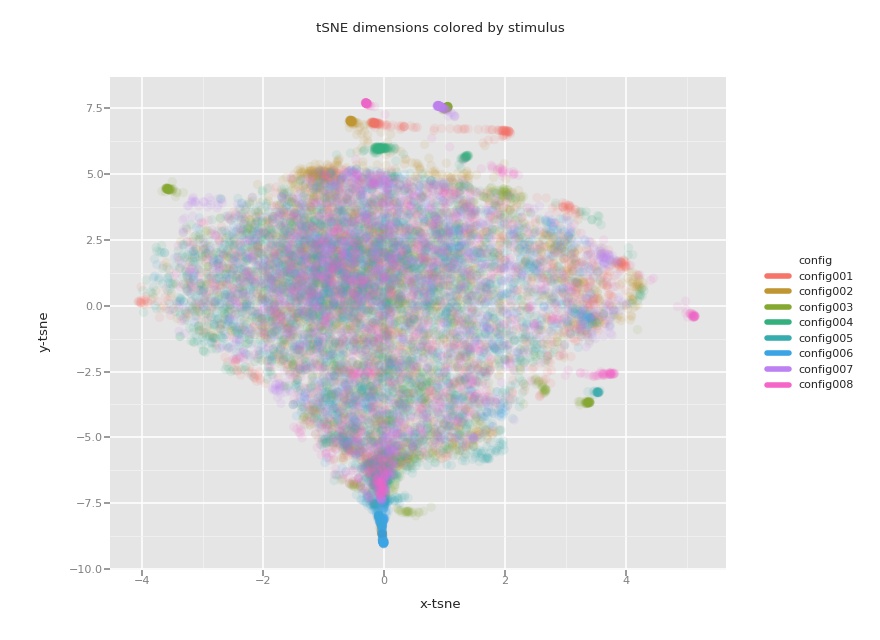

<ggplot: (8771238203997)>

In [258]:
df_tsne = dataset.copy()
df_tsne['x-tsne'] = tsne_results[:,0]
df_tsne['y-tsne'] = tsne_results[:,1]

chart = ggplot( df_tsne, aes(x='x-tsne', y='y-tsne', color='config') ) \
        + geom_point(size=70,alpha=0.1) \
        + ggtitle("tSNE dimensions colored by stimulus")
chart

# t-SNE with PCA-reduced data
#### t-SNE on reduced sample (PCA 75):

In [243]:
pca_75 = PCA(n_components=75)

pca_result_75 = pca_75.fit_transform(dataset[feat_cols].values)
print 'Cumulative explained variation for 75 principal components: {}'.format(np.sum(pca_75.explained_variance_ratio_))



Cumulative explained variation for 75 principal components: 0.820868505849


In [262]:
time_start = time.time()
tsne = TSNE(n_components=3, verbose=1, perplexity=40, n_iter=300)
tsne_pca_results = tsne.fit_transform(pca_result_75)
print 't-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start)


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 14320 samples in 0.027s...
[t-SNE] Computed neighbors for 14320 samples in 21.198s...
[t-SNE] Computed conditional probabilities for sample 1000 / 14320
[t-SNE] Computed conditional probabilities for sample 2000 / 14320
[t-SNE] Computed conditional probabilities for sample 3000 / 14320
[t-SNE] Computed conditional probabilities for sample 4000 / 14320
[t-SNE] Computed conditional probabilities for sample 5000 / 14320
[t-SNE] Computed conditional probabilities for sample 6000 / 14320
[t-SNE] Computed conditional probabilities for sample 7000 / 14320
[t-SNE] Computed conditional probabilities for sample 8000 / 14320
[t-SNE] Computed conditional probabilities for sample 9000 / 14320
[t-SNE] Computed conditional probabilities for sample 10000 / 14320
[t-SNE] Computed conditional probabilities for sample 11000 / 14320
[t-SNE] Computed conditional probabilities for sample 12000 / 14320
[t-SNE] Computed conditional probabilities for s

#### Visualize

<IPython.core.display.Javascript object>


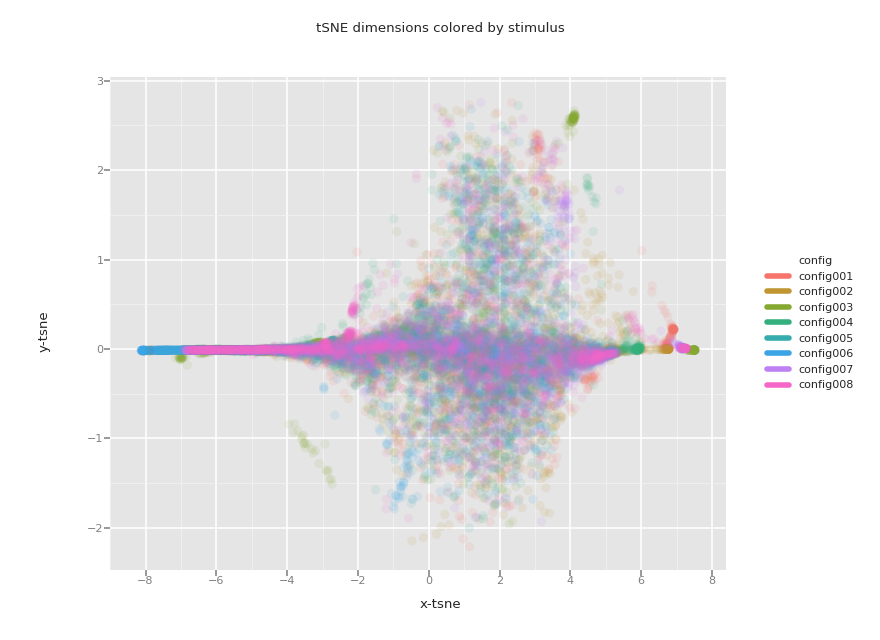

<ggplot: (8771321514893)>

In [260]:
df_pca_tsne = dataset.copy()
df_pca_tsne['x-tsne'] = tsne_pca_results[:,0]
df_pca_tsne['y-tsne'] = tsne_pca_results[:,1]

chart = ggplot( df_pca_tsne, aes(x='x-tsne', y='y-tsne', color='config') ) \
        + geom_point(size=70,alpha=0.1) \
        + ggtitle("tSNE dimensions colored by stimulus")
chart

In [261]:
tsne_results.shape

(14320, 2)

# t-SNE:  single stimulus type

In [264]:
currconfig = 'config007'
configdf = dataset[dataset['config']==currconfig]

#### First, run on all components:

In [266]:
#n_sne = 7000

time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
#tsne_results = tsne.fit_transform(df.loc[rndperm[:n_sne],feat_cols].values)
tsne_config_results = tsne.fit_transform(configdf[feat_cols].values)
print 't-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start)



[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1790 samples in 0.002s...
[t-SNE] Computed neighbors for 1790 samples in 0.447s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1790
[t-SNE] Computed conditional probabilities for sample 1790 / 1790
[t-SNE] Mean sigma: 0.333050
[t-SNE] KL divergence after 250 iterations with early exaggeration: 79.429520
[t-SNE] Error after 300 iterations: 2.199006
t-SNE done! Time elapsed: 9.96563601494 seconds


<IPython.core.display.Javascript object>


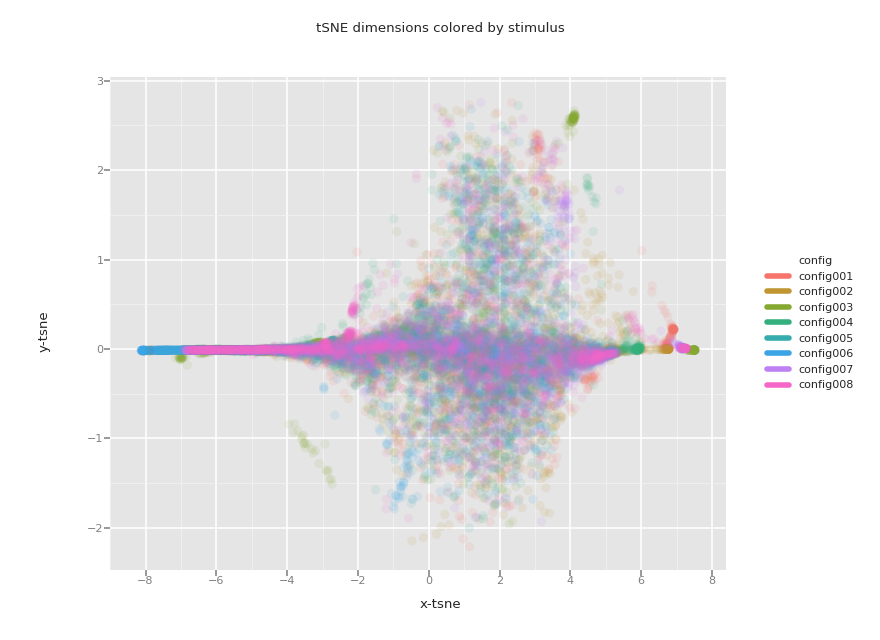

<ggplot: (8771263381661)>

In [280]:
df_config_tsne = configdf.copy()
df_config_tsne['x-tsne'] = tsne_config_results[:,0]
df_config_tsne['y-tsne'] = tsne_config_results[:,1]

chart = ggplot( df_pca_tsne, aes(x='x-tsne', y='y-tsne', color='config') ) \
        + geom_point(size=70,alpha=0.1) \
        + ggtitle("tSNE dimensions colored by stimulus")
chart

#### tSNE for each stimulus:

In [269]:
config_list

[u'config001',
 u'config002',
 u'config003',
 u'config004',
 u'config005',
 u'config006',
 u'config007',
 u'config008']

In [271]:
#currconfig = 'config007'
tsne_configs = {}
for currconfig in config_list:
    configdf = dataset[dataset['config']==currconfig]
    time_start = time.time()
    tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
    tsne_config_results = tsne.fit_transform(configdf[feat_cols].values)
    tsne_configs[currconfig] = tsne_config_results
    print '{}-- t-SNE done! Time elapsed: {} seconds'.format(currconfig, time.time()-time_start)


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1790 samples in 0.002s...
[t-SNE] Computed neighbors for 1790 samples in 0.436s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1790
[t-SNE] Computed conditional probabilities for sample 1790 / 1790
[t-SNE] Mean sigma: 0.336624
[t-SNE] KL divergence after 250 iterations with early exaggeration: 78.126938
[t-SNE] Error after 300 iterations: 2.250755
config001-- t-SNE done! Time elapsed: 10.4703550339 seconds
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1790 samples in 0.002s...
[t-SNE] Computed neighbors for 1790 samples in 0.452s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1790
[t-SNE] Computed conditional probabilities for sample 1790 / 1790
[t-SNE] Mean sigma: 0.330508
[t-SNE] KL divergence after 250 iterations with early exaggeration: 79.623451
[t-SNE] Error after 300 iterations: 2.278248
config002-- t-SNE done! Time elapsed: 10.4478991032 seconds
[t-SNE] Computing 121 neares

<IPython.core.display.Javascript object>


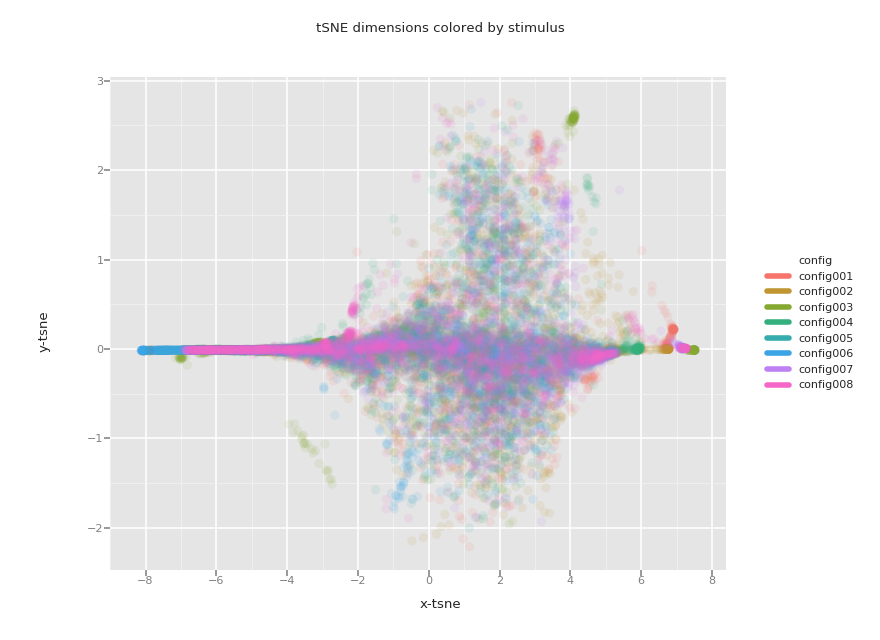

<ggplot: (8771117806361)>

In [281]:
df_config_tsne = configdf.copy()
df_config_tsne['x-tsne'] = tsne_config_results[:,0]
df_config_tsne['y-tsne'] = tsne_config_results[:,1]

chart = ggplot( df_pca_tsne, aes(x='x-tsne', y='y-tsne', color='config') ) \
        + geom_point(size=70,alpha=0.1) \
        + ggtitle("tSNE dimensions colored by stimulus")
chart